SMB、HML两个指标的计算方式如下：
1. 首先，按市值大小平均分为两组(Small 组, Big 组)，基准是这一时间的市场上公司市值中位数;
2. 按 BM 从小到大分三组,即前 30%(Growth 组),中间 40%(Neutral 组),后 30%(Value 组)；
3. 每个组的月回报以组内所有成员股票当月回报的加权平均数为依据,计算每个月的 SMB 和 HML 值。具体计算公式如下: 
   SMB = Small size return - Big size return)
   HML = Value company return - Growth company return
4. 以市场回报减去无风险回报,即得到超额市场回报(Rm-Rf)。（由于Ricequant平台无法提取国债收益率，我只能对这个时段的所有IBO1M求平均值作为无风    险回报率

# %pdb

# %load fama.py

In [1]:
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

In [2]:
research_starttime='2010-04-01'
research_endtime='2018-04-01'
format='%Y-%m-%d %H:%M:%S'
data_type=""#"net"
data_mode=""#"fast"
data_mode_global=data_mode

### 定义基础数据获取函数

In [3]:
## 从网络获取数据
#market_cap 指定证券收盘价 x 总股本 x 交易币种兑人民币汇率
def get_dp():
        interval_month=24
        # date_range=pd.date_range(research_starttime,research_endtime)
        # len(date_range)/31
        # pd.to_datetime(research_endtime)-(pd.to_datetime(research_endtime)-pd.to_datetime(research_starttime))/4
        # print(datetime.date.today() +relativedelta(months=-1))
        step0=pd.to_datetime(research_endtime)
        step1=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*1)
        step2=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*2)
        step3=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*3)
        step4=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*4)
        
        #网络请求API
        def get_years_fundamentals(interval_month,enddate):
            return get_fundamentals(
                query(fundamentals.eod_derivative_indicator.market_cap,fundamentals.financial_indicator.book_value_per_share,fundamentals.financial_indicator.return_on_equity,fundamentals.balance_sheet.total_assets)
                ,enddate, str(interval_month)+'m')
        
        # arr data
        dp_arr = [get_years_fundamentals(interval_month,step0),
                  get_years_fundamentals(interval_month,step1),
                  get_years_fundamentals(interval_month,step2),
                  get_years_fundamentals(interval_month,step3)]
        dp_arr
        
        # merge data 
        dp_merge=pd.concat(dp_arr,axis=1)#,ignore_index=True
        return dp_merge
        
#转换索引
def trans_index(df):
    if(type(df.index[0])==str):
        df.index=pd.to_datetime(df.index)
    return df
        
#get_all_instruments
def all_instruments_cs():
    df_market=None
    if(data_type=="net"):
        df_market = all_instruments(type='CS')
    else:
        df_market=pd.read_csv("all_instruments.csv",index_col=0)
    return df_market

#get_price_cs
def get_price_cs(data_starttime,data_endtime):
    df_price_data=None
    df_market=all_instruments_cs()
    if(data_type=="net"):
        df_price_data = get_price(list(df_market['order_book_id']),start_date=data_starttime, end_date=data_endtime,frequency='1d',fields='close')
    else:
        df_price_data=pd.read_csv("price_data.csv",index_col=0)
        df_price_data=trans_index(df_price_data)
    return df_price_data

#转换Series
def trans_series(df,key=1):
    if(type(df)==pd.DataFrame):
        df=df[key]
    return df


In [4]:
df_book_value=None
df_market_cap=None
df_return_on_equity=None
df_total_assets=None

#网络获取方式
if(data_type=="net"):
    dp_merge=get_dp()
    df_book_value=dp_merge["book_value_per_share"]
    df_market_cap=dp_merge["market_cap"]
    df_return_on_equity=dp_merge["return_on_equity"]
    df_total_assets=dp_merge["total_assets"]
    
    df_book_value=df_book_value[::-1]
    df_market_cap=df_market_cap[::-1]    
    df_return_on_equity=df_return_on_equity[::-1]    
    df_total_assets=df_total_assets[::-1]    
else:
#本地获取方式
    df_book_value=pd.read_csv("./book_value_per_share.csv",index_col=0)
    df_market_cap=pd.read_csv("./market_cap.csv",index_col=0)
    df_return_on_equity=pd.read_csv("./return_on_equity.csv",index_col=0)
    df_total_assets=pd.read_csv("./total_assets.csv",index_col=0)
    df_book_value=trans_index(df_book_value)
    df_market_cap=trans_index(df_market_cap)
    df_return_on_equity=trans_index(df_return_on_equity)    
    df_total_assets=trans_index(df_total_assets)    
    


In [5]:
df_book_value

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2010-04-02,6.59,3.4000,0.7033,0.8100,4.1600,-0.1580,0.9956,1.8400,0.3100,1.1098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,7.12,3.5500,0.7274,0.7600,4.2200,-0.3681,0.9947,2.0800,0.3100,1.1148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,7.12,3.5500,0.7274,0.7600,4.2200,-0.3681,0.9947,2.0800,0.3100,1.1148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,7.12,3.5500,0.7274,0.7600,4.2200,-0.3681,0.9947,2.0800,0.3100,1.1148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-06,7.12,3.5500,0.7274,0.7600,4.2200,-0.3681,0.9947,2.0800,0.3100,1.3221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-08,8.73,3.6200,0.7707,0.7510,2.6500,-0.3113,0.9958,2.0400,0.2974,1.3221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-08,8.73,3.6200,0.7707,0.7510,2.6500,-0.3113,0.9958,2.0400,0.2974,1.3221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-10,9.22,3.6600,0.8411,0.7390,2.7500,-0.3448,0.9967,2.2200,0.3130,1.3377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,9.22,3.6600,0.8411,0.7390,2.7500,-0.3448,0.9967,2.2200,0.3130,1.3377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,9.22,3.6600,0.8411,0.7390,2.7500,-0.3448,0.9967,2.2200,0.3130,1.3377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_market_cap

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2010-04-02,7.276031e+10,1.074232e+11,9.531354e+08,5.550005e+09,6.207923e+09,1.433482e+09,1.014941e+09,1.337260e+10,2.109700e+09,7.342462e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,6.210868e+10,8.191432e+10,8.288499e+08,4.205935e+09,4.473356e+09,1.520415e+09,9.096171e+08,1.228185e+10,2.150865e+09,4.583079e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,5.372400e+10,8.004513e+10,7.725855e+08,3.858488e+09,4.153831e+09,1.333600e+09,1.013468e+09,1.055847e+10,2.150865e+09,4.189733e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,6.102259e+10,7.762618e+10,7.037246e+08,3.538471e+09,4.161439e+09,1.300307e+09,7.365321e+08,8.671467e+09,2.150865e+09,4.827431e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-06,6.102259e+10,8.796168e+10,8.221317e+08,4.169361e+09,6.808935e+09,1.385391e+09,8.389100e+08,1.104930e+10,2.150865e+09,5.608163e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-08,6.151049e+10,9.422895e+10,9.497763e+08,4.370515e+09,6.162277e+09,1.451978e+09,9.479168e+08,1.360166e+10,2.150865e+09,5.208857e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-08,6.001194e+10,9.279957e+10,9.606933e+08,4.004781e+09,5.690596e+09,1.524115e+09,9.928452e+08,1.323080e+10,2.150865e+09,4.946626e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-10,6.318330e+10,1.006062e+11,1.137884e+09,4.096215e+09,5.629734e+09,1.646192e+09,1.024516e+09,1.902269e+10,2.150865e+09,5.125420e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,5.694512e+10,8.906120e+10,1.039631e+09,3.492754e+09,5.789497e+09,1.562957e+09,8.912038e+08,1.773560e+10,2.150865e+09,4.261251e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,5.642237e+10,9.928675e+10,1.008560e+09,3.465324e+09,6.101415e+09,1.622146e+09,8.750001e+08,1.657941e+10,2.150865e+09,4.714195e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_return_on_equity

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2010-04-02,27.2887,15.3888,-3.5235,-1.5711,17.5935,NaN,0.4284,13.5694,16.4939,15.7353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,7.4126,2.9509,-0.1331,-0.9862,1.7952,NaN,-0.0824,3.8134,-2.9945,0.4284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,7.4126,2.9509,-0.1331,-0.9862,1.7952,NaN,-0.0824,3.8134,-2.9945,0.4284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,7.4126,2.9509,-0.1331,-0.9862,1.7952,NaN,-0.0824,3.8134,-2.9945,0.4284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-06,7.4126,2.9509,-0.1331,-0.9862,1.7952,NaN,-0.0824,3.8134,-2.9945,17.4904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-08,11.9201,7.2911,5.5388,-2.3054,4.8008,NaN,0.0230,8.9457,-7.7647,17.4904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-08,11.9201,7.2911,5.5388,-2.3054,4.8008,NaN,0.0230,8.9457,-7.7647,17.4904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-10,17.9951,8.4296,14.0997,-3.8508,6.2662,NaN,0.1195,11.4174,-2.6648,18.5447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,17.9951,8.4296,14.0997,-3.8508,6.2662,NaN,0.1195,11.4174,-2.6648,18.5447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,17.9951,8.4296,14.0997,-3.8508,6.2662,NaN,0.1195,11.4174,-2.6648,18.5447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_total_assets

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2010-04-02,5.878110e+11,1.376086e+11,1.842607e+08,1.329657e+09,7.272028e+09,4.219999e+08,7.940798e+07,7.502010e+09,2.398579e+08,2.834418e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,6.199276e+11,1.483960e+11,2.182259e+08,1.308876e+09,7.701140e+09,3.458523e+08,7.983640e+07,9.259596e+09,2.150322e+08,2.907826e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,6.199276e+11,1.483960e+11,2.182259e+08,1.308876e+09,7.701140e+09,3.458523e+08,7.983640e+07,9.259596e+09,2.150322e+08,2.907826e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,6.199276e+11,1.483960e+11,2.182259e+08,1.308876e+09,7.701140e+09,3.458523e+08,7.983640e+07,9.259596e+09,2.150322e+08,2.907826e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-06,6.199276e+11,1.483960e+11,2.182259e+08,1.308876e+09,7.701140e+09,3.458523e+08,7.983640e+07,9.259596e+09,2.150322e+08,2.769294e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-08,6.243982e+11,1.605127e+11,2.256770e+08,1.316129e+09,7.533026e+09,3.488154e+08,7.735679e+07,9.029187e+09,2.158706e+08,2.769294e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-08,6.243982e+11,1.605127e+11,2.256770e+08,1.316129e+09,7.533026e+09,3.488154e+08,7.735679e+07,9.029187e+09,2.158706e+08,2.769294e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-10,6.750639e+11,1.879353e+11,1.860109e+08,1.299482e+09,8.054597e+09,2.943772e+08,7.754770e+07,9.767944e+09,2.210542e+08,2.895754e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,6.750639e+11,1.879353e+11,1.860109e+08,1.299482e+09,8.054597e+09,2.943772e+08,7.754770e+07,9.767944e+09,2.210542e+08,2.895754e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,6.750639e+11,1.879353e+11,1.860109e+08,1.299482e+09,8.054597e+09,2.943772e+08,7.754770e+07,9.767944e+09,2.210542e+08,2.895754e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


计算说明：
dp_merge.major_xs("2018-03-30")


In [9]:
# df_book_value=df_book_value[::-1]
# df_book_value0=df_book_value.dropna(axis=1,how="all")
# df_book_value=df_book_value0.sort_index()
index_date = df_book_value.index
stocks = df_book_value.columns
data_count=len(index_date)
data_starttime=index_date[0]
data_endtime=index_date[-1]
data_starttime,data_endtime

(Timestamp('2010-04-02 00:00:00'), Timestamp('2018-03-30 00:00:00'))

In [10]:
#all_instruments_cs
df_market = all_instruments_cs()
print("df_market['order_book_id']=",len(df_market['order_book_id']),df_market['order_book_id']);

df_market['order_book_id']= 3631 0       002322.XSHE
1       601877.XSHG
2       002480.XSHE
3       002735.XSHE
4       000839.XSHE
5       603966.XSHG
6       300521.XSHE
7       002202.XSHE
8       300160.XSHE
9       002025.XSHE
10      002011.XSHE
11      600261.XSHG
12      000759.XSHE
13      603421.XSHG
14      600635.XSHG
15      300151.XSHE
16      000776.XSHE
17      002702.XSHE
18      000968.XSHE
19      002013.XSHE
20      000756.XSHE
21      600672.XSHG
22      300095.XSHE
23      300553.XSHE
24      002718.XSHE
25      603089.XSHG
26      002205.XSHE
27      000951.XSHE
28      300302.XSHE
29      300515.XSHE
           ...     
3601    002490.XSHE
3602    603685.XSHG
3603    002156.XSHE
3604    600966.XSHG
3605    600606.XSHG
3606    002453.XSHE
3607    300255.XSHE
3608    603458.XSHG
3609    300379.XSHE
3610    000875.XSHE
3611    000667.XSHE
3612    600583.XSHG
3613    300223.XSHE
3614    002569.XSHE
3615    300359.XSHE
3616    300050.XSHE
3617    002157.XSHE
3618   

In [11]:
df_price_data0 = get_price_cs(data_starttime,data_endtime)#columns是乱序
df_price_data0#3631
# df_price_data#3514
# df_price_data0['000001.XSHE']

,603186.XSHG,000062.XSHE,300643.XSHE,600315.XSHG,300146.XSHE,000990.XSHE,300631.XSHE,300363.XSHE,600551.XSHG,603656.XSHG,...,601857.XSHG,000825.XSHE,000543.XSHE,002917.XSHE,000569.XSHE,000732.XSHE,600696.XSHG,603288.XSHG,002725.XSHE,002246.XSHE
2010-04-02,NaN,9.6163,NaN,18.0081,NaN,14.8820,NaN,NaN,15.5627,NaN,...,10.5334,7.7195,4.9641,NaN,NaN,1.9866,7.22,NaN,NaN,11.6093
2010-04-06,NaN,9.5244,NaN,18.5700,NaN,15.1620,NaN,NaN,15.2372,NaN,...,10.5334,7.6462,5.0109,NaN,NaN,1.9866,7.17,NaN,NaN,11.7370
2010-04-07,NaN,9.4234,NaN,18.5747,NaN,15.5483,NaN,NaN,15.3205,NaN,...,10.4766,7.8111,4.9589,NaN,NaN,1.9866,7.22,NaN,NaN,11.9540
2010-04-08,NaN,9.4693,NaN,19.1133,NaN,15.6449,NaN,NaN,15.8049,NaN,...,10.3548,7.5913,4.8860,NaN,NaN,1.9866,7.13,NaN,NaN,11.7498
2010-04-09,NaN,9.6347,NaN,19.2201,NaN,15.7801,NaN,NaN,15.8503,NaN,...,10.3954,7.6462,4.9173,NaN,NaN,1.9866,7.15,NaN,NaN,12.1774
2010-04-12,NaN,9.7724,NaN,19.9120,NaN,16.1567,NaN,NaN,16.4786,NaN,...,10.3548,7.4173,4.8444,NaN,NaN,1.9866,7.00,NaN,NaN,12.1774
2010-04-13,NaN,9.4785,NaN,20.1860,NaN,15.6932,NaN,NaN,16.4862,NaN,...,10.5902,7.4997,4.7612,NaN,NaN,1.9866,6.87,NaN,NaN,11.9795
2010-04-14,NaN,10.4245,NaN,19.8335,NaN,15.7608,NaN,NaN,17.1674,NaN,...,10.5253,7.5089,4.7872,NaN,NaN,1.9866,6.94,NaN,NaN,11.8455
2010-04-15,NaN,10.1857,NaN,19.4014,NaN,15.9153,NaN,NaN,16.7662,NaN,...,10.7363,7.4081,4.7351,NaN,NaN,1.9866,6.77,NaN,NaN,11.6349
2010-04-16,NaN,9.9561,NaN,20.1074,NaN,16.6106,NaN,NaN,16.4634,NaN,...,10.5821,7.3440,4.7039,NaN,NaN,1.9866,6.71,NaN,NaN,11.7306


In [12]:
df_price_data=df_price_data0.reindex(index_date,columns=stocks)#月度价格数据
df_price_data

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2010-04-02,7.9167,7.8846,11.35,6.07,4.0482,5.1667,1.5816,6.4584,3.5875,11.5412,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,6.7577,6.0123,9.87,4.60,2.9171,5.4800,1.4175,5.9316,3.6575,7.2039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,5.8455,5.9351,9.20,4.22,2.7458,4.8067,1.5794,5.0993,3.6575,6.5856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,5.9164,5.7558,8.38,3.87,2.7508,4.6867,1.1478,4.1880,3.6575,7.5879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-06,5.9164,6.5221,9.79,4.56,4.5008,4.9933,1.3073,5.3364,3.6575,8.8151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-08,5.9637,6.9868,11.31,4.78,4.0734,5.2333,1.4772,6.5908,3.6575,8.1875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-08,5.8184,6.8809,11.44,4.38,3.7616,5.4933,1.5472,6.4111,3.6575,7.7753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-10,6.1259,7.4597,13.55,4.48,3.7214,5.9333,1.5966,9.2176,3.6575,8.0563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,5.5211,6.6037,12.38,3.82,3.8270,5.6333,1.3888,8.5939,3.6575,6.6980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,5.4704,7.3619,12.01,3.79,4.0331,5.8467,1.3636,8.0337,3.6575,7.4100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#save data to reuse offline
# df_book_value.to_csv("book_value_per_share.csv")
# df_market_cap.to_csv("market_cap.csv")
# df_market.to_csv("all_instruments.csv")
# df_price_data.to_csv("price_data.csv")


In [14]:
#btm 函数定义
def get_btm(df_book_value,df_price_data):
    btm=df_book_value/df_price_data#3631
#     btm2=btm.dropna(axis=1,how="all")
    # b2m2[~np.isnan(b2m2['000003.XSHE'])]
    return btm     

In [15]:
#需要传入月度数据df_price_data
btm=get_btm(df_book_value,df_price_data)
btm

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2010-04-02,0.832418,0.431220,0.061965,0.133443,1.027617,-0.030580,0.629489,0.284900,0.086411,0.096160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,1.053613,0.590456,0.073698,0.165217,1.446642,-0.067172,0.701728,0.350664,0.084757,0.154750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,1.218031,0.598137,0.079065,0.180095,1.536893,-0.076581,0.629796,0.407899,0.084757,0.169278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,1.203435,0.616769,0.086802,0.196382,1.534099,-0.078541,0.866614,0.496657,0.084757,0.146918,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-06,1.203435,0.544303,0.074300,0.166667,0.937611,-0.073719,0.760881,0.389776,0.084757,0.149981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-08,1.463856,0.518120,0.068143,0.157113,0.650562,-0.059484,0.674113,0.309522,0.081312,0.161478,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-08,1.500412,0.526094,0.067369,0.171461,0.704487,-0.056669,0.643614,0.318198,0.081312,0.170038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-10,1.505085,0.490636,0.062074,0.164955,0.738969,-0.058113,0.624264,0.240844,0.085578,0.166044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,1.669957,0.554235,0.067940,0.193455,0.718579,-0.061207,0.717670,0.258323,0.085578,0.199716,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,1.685434,0.497154,0.070033,0.194987,0.681858,-0.058973,0.730933,0.276336,0.085578,0.180526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#是否需要做价格回溯，即不存在时，往前找
def get_return_data(index_date,df_price_data):
    df_price_data2=df_price_data.reindex(index_date)
    df_price_data3=df_price_data2.sort_index()
    df_price_data4=df_price_data3.pct_change()
#     df_price_data5=df_price_data4.dropna(axis=1,how="all")
#     df_price_data6=df_price_data5.sort_index(ascending=False)
    return df_price_data4
# df_price_data6


In [17]:
# return_data=None
# if(data_mode=="fast"):
#     return_data=pd.read_csv("return_data.csv",index_col=0)
#     return_data=trans_index(return_data)
# else:
#     return_data=get_return_data(index_date,stocks,df_price_data)
return_data=get_return_data(index_date,df_price_data)
return_data

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2010-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,-0.146399,-0.237463,-0.130396,-0.242175,-0.279408,0.060638,-0.103756,-0.081568,0.019512,-0.375810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,-0.134987,-0.012840,-0.067882,-0.082609,-0.058723,-0.122865,0.114215,-0.140316,0.000000,-0.085829,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,0.012129,-0.030210,-0.089130,-0.082938,0.001821,-0.024965,-0.273268,-0.178711,0.000000,0.152196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-06,0.000000,0.133135,0.168258,0.178295,0.636179,0.065419,0.138961,0.274212,0.000000,0.161731,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-08,0.007995,0.071250,0.155260,0.048246,-0.094961,0.048064,0.129963,0.235065,0.000000,-0.071196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-08,-0.024364,-0.015157,0.011494,-0.083682,-0.076545,0.049682,0.047387,-0.027265,0.000000,-0.050345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-10,0.052850,0.084117,0.184441,0.022831,-0.010687,0.080098,0.031929,0.437756,0.000000,0.036140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,-0.098728,-0.114750,-0.086347,-0.147321,0.028376,-0.050562,-0.130152,-0.067664,0.000000,-0.168601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,-0.009183,0.114814,-0.029887,-0.007853,0.053854,0.037882,-0.018145,-0.065186,0.000000,0.106300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# return_data.to_csv("return_data.csv")

#### 因子计算函数

In [19]:
def cumulative_cap(date,stk_market_cap,valid_total_market_cap):
    if(date in valid_total_market_cap):
        valid_total_market_cap[date]=valid_total_market_cap[date]+stk_market_cap
    else:
        valid_total_market_cap[date]=0.0

def recordnan_withstk(stk,date,nan_map):
    datestr=date.strftime("%F")
    nan_skt_map=nan_map.get(stk)
    if(nan_skt_map):
        if(datestr not in nan_skt_map):
            nan_skt_map.append(datestr)
    else:
        nan_map[stk]=[datestr]
        
def recordnan_withdate(stk,date,nan_map):
    datestr=date.strftime("%F")
    nan_skt_map=nan_map.get(datestr)
    if(nan_skt_map):
        if(stk not in nan_skt_map):
            nan_skt_map.append(stk)
    else:
        nan_map[datestr]=[stk]
#获得二分组
def get_2group(index_date,factor_data,recordnan):  
    median_size = {}
    smallgroup = {}
    middlegroup = {}
    biggroup = {}
    nan_map={}
    stocks=factor_data.columns
    for date in index_date:
        median_size[date] = np.median(factor_data.loc[date].dropna())
        factor_data_dropna=factor_data.loc[date].dropna()
        if(len(factor_data_dropna)>0):
            median_size[date] = np.median(factor_data_dropna)
        else:
            median_size[date]=0
    for date in index_date:
        smallgroup[date]=[]
        middlegroup[date]=[]
        biggroup[date]=[]
        for stk in stocks:
            if(np.isnan(factor_data[stk][date])):
                recordnan(stk,date,nan_map)
                continue
            #计算factor分组
            if factor_data[stk][date]<median_size[date]:
                smallgroup[date].append(stk)
            elif factor_data[stk][date]>median_size[date]:
                biggroup[date].append(stk)
            elif factor_data[stk][date]==median_size[date]:
                middlegroup[date].append(stk)
            else:
                recordnan(stk,date,nan_map)

    return {"smallgroup":smallgroup,"middlegroup":middlegroup,"biggroup":biggroup,
            "median_size":median_size,"nan_map":nan_map}
        
#获得三分组
def get_3group(index_date,factor_data,recordnan):
    lmark = {}
    hmark = {}
    smallgroup = {}
    middlegroup = {}
    biggroup = {}
    nan_map={}
    stocks=factor_data.columns
    for date in index_date:
        factor_data_dropna=factor_data.loc[date].dropna()
        if(len(factor_data_dropna)>0):
            lmark[date] = np.percentile(factor_data_dropna,30)
            hmark[date] = np.percentile(factor_data_dropna,70)
        else:
            lmark[date]=0
            hmark[date]=0
    for date in index_date:
        smallgroup[date]=[]
        middlegroup[date]=[]
        biggroup[date]=[]
        for stk in stocks:
            if(np.isnan(factor_data[stk][date])):
                recordnan(stk,date,nan_map)
                continue
            #计算factor分组
            if factor_data[stk][date]<=lmark[date]:
                smallgroup[date].append(stk)
                
            elif factor_data[stk][date]>=hmark[date]:
                biggroup[date].append(stk)

            elif(lmark[date]<factor_data[stk][date]<hmark[date]):#middle
                middlegroup[date].append(stk)
            else:
                recordnan(stk,date,nan_map)

    return {"smallgroup":smallgroup,"middlegroup":middlegroup,"biggroup":biggroup,
            "lmark":lmark,"hmark":hmark,"nan_map":nan_map}

#计算每一小组总回报
def get_group_return(index_date,group,return_data,df_market_cap,nan_map,valid_total_market_cap,recordnan=recordnan_withstk):
    group_return={}
    for date in index_date:
        group_return[date]=0.0
        group_stocks=group[date]
        
        for stk in group_stocks:
            if(np.isnan(df_market_cap[stk][date]) or np.isnan(return_data[stk][date])):
                recordnan(stk,date,nan_map)
                continue
            group_return[date]=group_return[date]+return_data[stk][date]*df_market_cap[stk][date]
            cumulative_cap(date,df_market_cap[stk][date],valid_total_market_cap)
    return  group_return
    
#计算三分组因子#factor_type "smb/bms" 两分组的也能用
def get_3group_factor(index_date,factor_3group,return_data,df_market_cap,recordnan=recordnan_withstk,factor_type="smb"):
    factor = pd.Series(index = index_date)
    valid_total_market_cap={}
    nan_map={}
    #计算factor
    smallgroup_return=get_group_return(index_date,factor_3group["smallgroup"],return_data,df_market_cap,nan_map,valid_total_market_cap,recordnan)
#     middlegroup_return=get_group_return(index_date,factor_3group["middlegroup"],return_data,df_market_cap,nan_map,valid_total_market_cap,recordnan)
    biggroup_return=get_group_return(index_date,factor_3group["biggroup"],return_data,df_market_cap,nan_map,valid_total_market_cap,recordnan)
    
    for date in index_date:
        if(date not in valid_total_market_cap):
            factor[date]=0
            continue
            
        smallgroup=smallgroup_return[date]
        biggroup=biggroup_return[date]
        mktcap = valid_total_market_cap[date]
        netgroup=smallgroup - biggroup
        if(factor_type=="bms"):
            netgroup=biggroup-smallgroup
        factor[date] = netgroup/mktcap#每日回报率＝每日总回报/总市值
        
    return factor

#获取hml因子
def get_factor_hml(index_date,factor_data,return_data,df_market_cap,recordnan=recordnan_withstk):
    if(data_mode=="fast"):
        factor=pd.read_csv("hml.csv",index_col=0,header=None)
        factor=trans_series(factor)
        factor=trans_index(factor)
    else:
        factor_3group=get_3group(index_date,factor_data,recordnan)
        factor=get_3group_factor(index_date,factor_3group,return_data,df_market_cap,recordnan,factor_type="bms")
    return factor

#获取盈利因子rmw
def get_factor_rmw(index_date,factor_data,return_data,df_market_cap,recordnan=recordnan_withstk):
    if(data_mode=="fast"):
        factor=pd.read_csv("rmw.csv",index_col=0,header=None)
        factor=trans_series(factor)
        factor=trans_index(factor)
    else:
        factor_3group=get_3group(index_date,factor_data,recordnan)
        factor=get_3group_factor(index_date,factor_3group,return_data,df_market_cap,recordnan,factor_type="bms")
    return factor  
#获取投资风格因子cma
def get_factor_cma(index_date,factor_data,return_data,df_market_cap,recordnan=recordnan_withstk):
    if(data_mode=="fast"):
        factor=pd.read_csv("cma.csv",index_col=0,header=None)
        factor=trans_series(factor)
        factor=trans_index(factor)
    else:
        factor_3group=get_3group(index_date,factor_data,recordnan)
        factor=get_3group_factor(index_date,factor_3group,return_data,df_market_cap,recordnan,factor_type="smb")
    return factor 

#获取市值因子smb
def get_factor_smb(index_date,factor_data,return_data,df_market_cap,recordnan=recordnan_withstk):
    if(data_mode=="fast"):
        factor=pd.read_csv("smb.csv",index_col=0,header=None)
        factor=trans_series(factor)
        factor=trans_index(factor)
    else:
        factor_2group=get_2group(index_date,factor_data,recordnan)
        factor=get_3group_factor(index_date,factor_2group,return_data,df_market_cap,recordnan,factor_type="smb")
    return factor 

In [20]:
hml=get_factor_hml(index_date,btm,return_data,df_market_cap,recordnan_withstk)
hml

2010-04-02    0.000000
2010-05-04   -0.071589
2010-06-04   -0.049275
2010-07-06   -0.005557
2010-08-06    0.015207
2010-09-08   -0.032602
2010-10-08   -0.031514
2010-11-10    0.018759
2010-12-10   -0.029972
2011-01-11    0.007826
2011-02-11   -0.008489
2011-03-11   -0.006618
2011-04-13    0.020230
2011-05-13   -0.018868
2011-06-15   -0.027779
2011-07-15   -0.008958
2011-08-16   -0.028497
2011-09-16    0.000335
2011-10-18    0.004735
2011-11-18   -0.003222
2011-12-20    0.009006
2012-01-20   -0.007342
2012-02-29   -0.014373
2012-03-30   -0.007823
2012-04-11   -0.011268
2012-05-11   -0.009420
2012-06-13   -0.018366
2012-07-13   -0.024731
2012-08-14    0.009694
2012-09-14   -0.003212
                ...   
2015-10-30    0.006602
2015-11-30   -0.024249
2015-12-31    0.005068
2016-02-01   -0.086866
2016-03-01    0.004257
2016-04-01    0.035953
2016-04-06   -0.001547
2016-05-06   -0.020999
2016-06-08   -0.006409
2016-07-12    0.006119
2016-08-12    0.016789
2016-09-14   -0.020628
2016-10-14 

In [21]:
smb=get_factor_smb(index_date,df_market_cap,return_data,df_market_cap,recordnan_withstk)
smb

2010-04-02    0.000000
2010-05-04    0.072521
2010-06-04    0.063869
2010-07-06    0.033867
2010-08-06   -0.090692
2010-09-08   -0.017744
2010-10-08   -0.024794
2010-11-10   -0.130030
2010-12-10    0.060862
2011-01-11    0.005458
2011-02-11   -0.007782
2011-03-11   -0.030101
2011-04-13   -0.033197
2011-05-13    0.041192
2011-06-15    0.032963
2011-07-15   -0.051744
2011-08-16    0.049584
2011-09-16    0.036984
2011-10-18    0.024557
2011-11-18   -0.013176
2011-12-20    0.050213
2012-01-20   -0.049039
2012-02-29   -0.039565
2012-03-30    0.047447
2012-04-11   -0.014933
2012-05-11   -0.033474
2012-06-13    0.009621
2012-07-13    0.025162
2012-08-14    0.011435
2012-09-14    0.007234
                ...   
2015-10-30   -0.089938
2015-11-30   -0.025595
2015-12-31   -0.025909
2016-02-01    0.151607
2016-03-01   -0.014541
2016-04-01   -0.075211
2016-04-06   -0.010317
2016-05-06    0.028574
2016-06-08   -0.018613
2016-07-12   -0.044721
2016-08-12   -0.011503
2016-09-14    0.011056
2016-10-14 

In [22]:
rmw=get_factor_rmw(index_date,df_return_on_equity,return_data,df_market_cap,recordnan_withstk)
rmw

2010-04-02    0.000000
2010-05-04   -0.059653
2010-06-04   -0.055799
2010-07-06   -0.021232
2010-08-06    0.068714
2010-09-08    0.009074
2010-10-08    0.022023
2010-11-10    0.112015
2010-12-10   -0.047111
2011-01-11   -0.003005
2011-02-11    0.001837
2011-03-11    0.015860
2011-04-13    0.023954
2011-05-13   -0.032229
2011-06-15   -0.024353
2011-07-15    0.031788
2011-08-16   -0.022648
2011-09-16   -0.031021
2011-10-18   -0.014331
2011-11-18    0.006063
2011-12-20   -0.030521
2012-01-20    0.046103
2012-02-29    0.021519
2012-03-30   -0.034879
2012-04-11    0.006767
2012-05-11    0.028260
2012-06-13   -0.013471
2012-07-13   -0.011125
2012-08-14   -0.001020
2012-09-14   -0.007077
                ...   
2015-10-30    0.052309
2015-11-30    0.026915
2015-12-31    0.018101
2016-02-01   -0.110696
2016-03-01   -0.001176
2016-04-01    0.060940
2016-04-06    0.005070
2016-05-06   -0.005344
2016-06-08    0.021405
2016-07-12    0.027043
2016-08-12    0.023506
2016-09-14   -0.006605
2016-10-14 

In [23]:
df_extra=pd.read_csv("extra_total_assets.csv",index_col=0)
df_extra=trans_index(df_extra)
# df_extra
# df_total_assets.append(df_extra)
df_total_assets_full=pd.concat([df_total_assets,df_extra])
df_total_assets_full=df_total_assets_full.sort_index()
df_total_assets_full
#df1.combine(df2, lambda s1, s2: s1 if s1.sum() < s2.sum() else s2)
df_asset_growth = df_total_assets_full.pct_change(periods=12)
factor_data=df_asset_growth
cma=get_factor_cma(index_date,factor_data,return_data,df_market_cap,recordnan_withstk)
cma

# 2010-04-02    0.000000
# 2010-05-04    0.051764
# 2010-06-04    0.045896
# 2010-07-06    0.022781
# 2010-08-06   -0.073459
# 2010-09-08   -0.016918

2010-04-02    0.000000
2010-05-04    0.051764
2010-06-04    0.045896
2010-07-06    0.022781
2010-08-06   -0.073459
2010-09-08   -0.016918
2010-10-08   -0.031813
2010-11-10   -0.088691
2010-12-10    0.028092
2011-01-11    0.002075
2011-02-11   -0.003402
2011-03-11   -0.017280
2011-04-13   -0.007224
2011-05-13    0.020267
2011-06-15    0.013084
2011-07-15   -0.058743
2011-08-16    0.005121
2011-09-16    0.034821
2011-10-18    0.027782
2011-11-18    0.000357
2011-12-20    0.013863
2012-01-20   -0.013198
2012-02-29   -0.027667
2012-03-30    0.020256
2012-04-11   -0.009407
2012-05-11   -0.024452
2012-06-13   -0.002426
2012-07-13   -0.003377
2012-08-14    0.008065
2012-09-14    0.005348
                ...   
2015-10-30   -0.047610
2015-11-30   -0.030947
2015-12-31   -0.013603
2016-02-01    0.051122
2016-03-01    0.005240
2016-04-01   -0.035842
2016-04-06   -0.007805
2016-05-06    0.008564
2016-06-08   -0.011418
2016-07-12   -0.003757
2016-08-12   -0.002698
2016-09-14   -0.000429
2016-10-14 

In [24]:
# df_asset_growth
# cma.to_csv("cma.csv")
# rmw.to_csv("rmw.csv")
# hml.to_csv("hml.csv")
# smb.to_csv("smb.csv")


In [25]:
#market (HuShen300)
def get_hs_market(data_starttime,data_endtime):
    s_hs_market=None
    if(data_mode=="net"):
        s_hs_market = get_price(['000300.XSHG'],start_date=data_starttime, end_date=data_endtime,frequency='1d',fields='close')
        # df_Rm_data=pd.read_csv("df_Rm_data.csv",index_col=0,header=None)
        type(df_hs_market)#pandas.core.series.Series
        s_hs_market
    else:
        s_hs_market=pd.read_csv("hs_market.csv",index_col=0,header=None)#
        #type(s_hs_market)==pandas.core.frame.DataFrame
    s_hs_market=trans_series(s_hs_market)    
    s_hs_market=trans_index(s_hs_market)
    return s_hs_market

In [26]:
s_hs_market=get_hs_market(data_starttime,data_endtime)
s_hs_market#沪深股票的行情是升序的，所以之前算错了


0
2010-04-02    3407.3460
2010-04-06    3405.1450
2010-04-07    3386.9490
2010-04-08    3346.7440
2010-04-09    3379.1700
2010-04-12    3351.4780
2010-04-13    3391.7160
2010-04-14    3403.7070
2010-04-15    3394.5740
2010-04-16    3356.3320
2010-04-19    3176.4230
2010-04-20    3173.3740
2010-04-21    3236.6790
2010-04-22    3201.5410
2010-04-23    3190.0030
2010-04-26    3171.9970
2010-04-27    3108.4090
2010-04-28    3097.3530
2010-04-29    3060.0640
2010-04-30    3067.3650
2010-05-04    3019.4490
2010-05-05    3036.3940
2010-05-06    2896.8560
2010-05-07    2836.7890
2010-05-10    2858.2330
2010-05-11    2800.8170
2010-05-12    2818.1600
2010-05-13    2886.9110
2010-05-14    2868.0230
2010-05-17    2714.7150
                ...    
2018-02-12    3890.1046
2018-02-13    3935.6324
2018-02-14    3966.9614
2018-02-22    4052.7332
2018-02-23    4071.0889
2018-02-26    4118.4186
2018-02-27    4058.9806
2018-02-28    4023.6415
2018-03-01    4049.0863
2018-03-02    4016.4610
2018-03-05    

In [27]:
#保存smb hml 因子
# smb.to_csv("smb.csv")
# hml.to_csv("hml.csv")
# s_hs_market.to_csv("hs_market.csv")

In [28]:
#处理无风险利率
def get_save_ratio():
    df_rmb_save_ratio=pd.read_csv("rmb_ratio_pure.csv",index_col=0,header=None)
    df_rmb_save_ratio=trans_index(df_rmb_save_ratio)
    # type(df_save_ratio.index[0])#pandas.tslib.Timestamp
    df_rmb_save_ratio=trans_series(df_rmb_save_ratio)
    return df_rmb_save_ratio
s_save_ratio=get_save_ratio()
s_save_ratio

0
1989-02-01    7.56
1990-04-15    6.30
1990-08-21    4.32
1991-04-21    3.24
1993-05-15    4.86
1993-07-11    6.66
1996-05-01    4.86
1996-08-23    3.33
1997-10-23    2.88
1998-03-25    2.88
1998-07-01    2.79
1998-12-07    2.79
1999-06-10    1.98
2002-02-21    1.71
2004-10-29    1.71
2006-08-19    1.80
2007-03-18    1.98
2007-05-19    2.07
2007-07-21    2.34
2007-08-22    2.61
2007-09-15    2.88
2007-12-21    3.33
2008-10-09    3.15
2008-10-30    2.88
2008-11-27    1.98
2008-12-23    1.71
2010-10-20    1.91
2010-12-26    2.25
2011-02-09    2.60
2011-04-06    2.85
2011-07-07    3.10
2012-06-08    2.85
2012-07-06    2.60
2014-11-22    2.35
2015-03-01    2.10
2015-05-11    1.85
2015-06-28    1.60
2015-08-26    1.35
2015-10-24    1.10
Name: 1, dtype: float64

In [29]:
#market return(HuShen300) and risk free return(0.375724091% 1M, for I can't get this rate from Ricequant nor can I upload my own data)
def get_rm(index_date,s_hs_market):
    Rm = pd.Series(index = index_date)
    if(data_mode=="fast"):
        Rm=pd.read_csv("rm.csv",index_col=0,header=None) 
        Rm=trans_series(Rm)
    else:
        s_hs_market2=s_hs_market.reindex(index_date)
        Rm=s_hs_market2.pct_change()
    return Rm

def get_rf(index_date,s_save_ratio):
    Rf = pd.Series(index = index_date)
    Rf0=s_save_ratio.reindex(index=index_date,method="pad")
    Rf=Rf0/100/12
    return Rf

def get_index_r(index_date,s_index):
    s_r = pd.Series(index = index_date)
    s_index2=s_index.reindex(index=index_date)
    s_r=s_index2.pct_change()
    return s_r

In [30]:
#change_mode
data_mode=""
Rm=get_rm(index_date,s_hs_market)
Rf=get_rf(index_date,s_save_ratio)
data_mode=data_mode_global

Rm_Rf=Rm-Rf
Rm_Rf
# Rf.to_csv("rf2.csv")
# s_save_ratio


2010-04-02         NaN
2010-05-04   -0.115266
2010-06-04   -0.092520
2010-07-06   -0.067556
2010-08-06    0.129191
2010-09-08    0.027325
2010-10-08    0.019798
2010-11-10    0.147831
2010-12-10   -0.097940
2011-01-11   -0.013594
2011-02-11   -0.003436
2011-03-11    0.038340
2011-04-13    0.036011
2011-05-13   -0.074717
2011-06-15   -0.055114
2011-07-15    0.053361
2011-08-16   -0.076510
2011-09-16   -0.059042
2011-10-18   -0.054441
2011-11-18    0.002928
2011-12-20   -0.090603
2012-01-20    0.050849
2012-02-29    0.049355
2012-03-30   -0.070630
2012-04-11    0.023950
2012-05-11    0.043797
2012-06-13   -0.023718
2012-07-13   -0.052543
2012-08-14   -0.040368
2012-09-14   -0.019763
                ...   
2015-10-30    0.102467
2015-11-30    0.008232
2015-12-31    0.045234
2016-02-01   -0.223365
2016-03-01    0.009302
2016-04-01    0.098446
2016-04-06    0.010143
2016-05-06   -0.039956
2016-06-08    0.009827
2016-07-12    0.033595
2016-08-12    0.005515
2016-09-14   -0.017765
2016-10-14 

In [31]:
#save rm and rf data
# Rm.to_csv("rm.csv")
# Rf.to_csv("rf.csv")

### 引入大数据因子

In [32]:
#引入大数据因子
s_bigdata=pd.read_csv("bigdata_pure.csv",index_col=0,header=None)
s_bigdata=trans_series(s_bigdata)
s_bigdata=trans_index(s_bigdata)

s_bigdata_r=get_index_r(index_date,s_bigdata)
s_bigdata_r
# s_bigdata=pd.to_numeric(s_bigdata)#处理不了含有千分位符号的数字字符串
# s=s_bigdata.apply(lambda x:float(x.replace(",","",2)))
# s.to_csv("bigdata_pure.csv")
# float("2,,333.00".replace(",","",3))
# s_bigdata_r.to_csv("bigdata_r.csv")


2010-04-02         NaN
2010-05-04   -0.165773
2010-06-04   -0.012993
2010-07-06   -0.074541
2010-08-06    0.126561
2010-09-08    0.082382
2010-10-08    0.043332
2010-11-10    0.441792
2010-12-10    0.066641
2011-01-11   -0.191509
2011-02-11    0.029434
2011-03-11    0.133943
2011-04-13   -0.072065
2011-05-13   -0.148079
2011-06-15   -0.040837
2011-07-15    0.154368
2011-08-16    0.104697
2011-09-16   -0.000418
2011-10-18   -0.041006
2011-11-18    0.085199
2011-12-20   -0.046430
2012-01-20   -0.140509
2012-02-29    0.476570
2012-03-30   -0.121134
2012-04-11    0.050751
2012-05-11   -0.028630
2012-06-13   -0.005073
2012-07-13   -0.051436
2012-08-14   -0.022242
2012-09-14    0.093518
                ...   
2015-10-30    0.289707
2015-11-30    0.158636
2015-12-31    0.090449
2016-02-01   -0.360591
2016-03-01   -0.056894
2016-04-01    0.217230
2016-04-06    0.040122
2016-05-06   -0.072566
2016-06-08    0.040393
2016-07-12    0.066959
2016-08-12   -0.027363
2016-09-14    0.004861
2016-10-14 

### 引入汇率因子

In [33]:
def get_exchange_day(index_date):
    if(data_mode=="fast"):
        s_exchange=pd.read_csv("exchange_day.csv",index_col=0,header=None)
        s_exchange=trans_series(s_exchange)
        pass
    else:
        exchange=pd.read_csv("USD_CNY历史数据.csv",index_col="日期")
        exchange['date']=[pd.to_datetime(datetime.datetime.strptime(date,"%Y年%m月%d日")) for date in exchange.index]
        exchange=exchange.set_index(exchange['date'])
        s_exchange=exchange["收盘"]
    s_exchange=s_exchange.reindex(index_date)
    return s_exchange

def get_exchange_rate(index_date):
    s_exchange=get_exchange_day(index_date)
    s_exchange_rate=s_exchange.pct_change()
    return s_exchange_rate

s_exchange_rate=get_exchange_rate(index_date)

In [34]:
#x = pd.DataFrame(index=index_date,columns=['Rm-Rf','SMB','HML'])
def get_df_X(index_date,factors):
    df_X=pd.DataFrame(factors,index=index_date)
    df_X = df_X[1:]
    return df_X
# df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml,"bigdata":s_bigdata_r})
# df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf})

In [35]:
df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml,"bigdata":s_bigdata_r,'RMW':rmw,'CMA':cma,'Exchange':s_exchange_rate})
# df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml})
# df_X.describe()
# df_X=get_df_X(index_date,{'SMB':smb,'HML':hml,'cma':cma})

df_X.corr(method='pearson')
# df_X3=df_X.drop("Rm_Rf",axis=1)
# df_X3=df_X3.drop("bigdata",axis=1)
# df_X3.corr(method='pearson')

# df_X.plot()
# X=df_X.values
# X
# df_X.cov()

# 	HML	Rm_Rf	SMB	bigdata
# HML	1.000000	0.620621	-0.577628	0.047892
# Rm_Rf	0.620621	1.000000	-0.976422	0.560603
# SMB	-0.577628	-0.976422	1.000000	-0.590060
# bigdata	0.047892	0.560603	-0.590060	1.000000

,CMA,Exchange,HML,RMW,Rm_Rf,SMB,bigdata
CMA,1.000000,0.119132,-0.326369,-0.792751,-0.847506,0.840351,-0.663594
Exchange,0.119132,1.000000,-0.262394,-0.172387,-0.153095,0.150496,-0.129433
HML,-0.326369,-0.262394,1.000000,0.665670,0.628058,-0.585750,0.050072
RMW,-0.792751,-0.172387,0.665670,1.000000,0.935246,-0.961277,0.466649
Rm_Rf,-0.847506,-0.153095,0.628058,0.935246,1.000000,-0.976652,0.560603
SMB,0.840351,0.150496,-0.585750,-0.961277,-0.976652,1.000000,-0.590051
bigdata,-0.663594,-0.129433,0.050072,0.466649,0.560603,-0.590051,1.000000


In [36]:
#get_stocks_r 计算某个数组的股票的收益率Series
#index_date 为观察的数据周期中的日期
#stocks 为要计算的股票数组
#return_data 为总的回报率数据
#df_market_cap 为总的市值数据
def get_stocks_r(index_date,stocks,return_data,df_market_cap):
    s_r = pd.Series(index = index_date)
#     median_size,lmark,hmark=get_div_point(index_date,df_market_cap,btm)
    for date in index_date:
        total_return=0.0
        total_cap=0.0
        for stk in stocks:
#             if(stk=="000022.XSHE"):#第一行为nan的原因，导致整个第一次的total_cap=0
#             print('----------',df_market_cap[stk][date],return_data[stk][date],stk,date)
            if(np.isnan(df_market_cap[stk][date]) or np.isnan(return_data[stk][date])):
                continue
            stock_date_cap=df_market_cap[stk][date]
            stock_date_return=return_data[stk][date]*stock_date_cap
            total_cap=total_cap+stock_date_cap
            total_return=total_return+stock_date_return

        if(total_cap!=0):
            s_r[date] = (total_return)/total_cap#每日回报率＝每日总回报/总市值
        else:
            s_r[date]=0
    return s_r

def get_yT(s_y): 
    y = np.array(s_y)
    y=y[1:]
    YT = y.T
    return YT
# y=get_y(return_data_ydyl,Rf)

In [37]:
# return_data["000022.XSHE"]
Rf

2010-04-02    0.001425
2010-05-04    0.001425
2010-06-04    0.001425
2010-07-06    0.001425
2010-08-06    0.001425
2010-09-08    0.001425
2010-10-08    0.001425
2010-11-10    0.001592
2010-12-10    0.001592
2011-01-11    0.001875
2011-02-11    0.002167
2011-03-11    0.002167
2011-04-13    0.002375
2011-05-13    0.002375
2011-06-15    0.002375
2011-07-15    0.002583
2011-08-16    0.002583
2011-09-16    0.002583
2011-10-18    0.002583
2011-11-18    0.002583
2011-12-20    0.002583
2012-01-20    0.002583
2012-02-29    0.002583
2012-03-30    0.002583
2012-04-11    0.002583
2012-05-11    0.002583
2012-06-13    0.002375
2012-07-13    0.002167
2012-08-14    0.002167
2012-09-14    0.002167
                ...   
2015-10-30    0.000917
2015-11-30    0.000917
2015-12-31    0.000917
2016-02-01    0.000917
2016-03-01    0.000917
2016-04-01    0.000917
2016-04-06    0.000917
2016-05-06    0.000917
2016-06-08    0.000917
2016-07-12    0.000917
2016-08-12    0.000917
2016-09-14    0.000917
2016-10-14 

In [38]:
# str(concept('一带一路'))
arr_ydyl=['000022.XSHE', '000042.XSHE', '000065.XSHE', '000088.XSHE', '000090.XSHE', '000151.XSHE', '000157.XSHE', '000159.XSHE', '000400.XSHE', '000425.XSHE', '000498.XSHE', '000507.XSHE', '000528.XSHE', '000564.XSHE', '000582.XSHE', '000610.XSHE', '000617.XSHE', '000672.XSHE', '000680.XSHE', '000703.XSHE', '000777.XSHE', '000797.XSHE', '000852.XSHE', '000862.XSHE', '000877.XSHE', '000905.XSHE', '000928.XSHE', '000939.XSHE', '000978.XSHE', '600026.XSHG', '600028.XSHG', '600031.XSHG', '600068.XSHG', '600089.XSHG', '600105.XSHG', '600118.XSHG', '600125.XSHG', '600150.XSHG', '600170.XSHG', '600176.XSHG', '600179.XSHG', '600190.XSHG', '600202.XSHG', '600256.XSHG', '600279.XSHG', '600312.XSHG', '600317.XSHG', '600320.XSHG', '600339.XSHG', '600350.XSHG', '600368.XSHG', '600406.XSHG', '600425.XSHG', '600428.XSHG', '600449.XSHG', '600477.XSHG', '600487.XSHG', '600495.XSHG', '600509.XSHG', '600522.XSHG', '600528.XSHG', '600540.XSHG', '600580.XSHG', '600581.XSHG', '600583.XSHG', '600706.XSHG', '600717.XSHG', '600720.XSHG', '600778.XSHG', '600798.XSHG', '600801.XSHG', '600820.XSHG', '600888.XSHG', '600984.XSHG', '002040.XSHE', '600970.XSHG', '002047.XSHE', '002051.XSHE', '600017.XSHG', '600018.XSHG', '601872.XSHG', '601008.XSHG', '002135.XSHE', '601919.XSHG', '002146.XSHE', '601808.XSHG', '601857.XSHG', '601390.XSHG', '601866.XSHG', '002205.XSHE', '002207.XSHE', '601186.XSHG', '601668.XSHG', '002266.XSHE', '601766.XSHG', '601727.XSHG', '601989.XSHG', '002302.XSHE', '002307.XSHE', '002309.XSHE', '601618.XSHG', '601117.XSHG', '300011.XSHE', '002323.XSHE', '002353.XSHE', '601179.XSHG', '601106.XSHG', '002459.XSHE', '300090.XSHE', '300103.XSHE', '601018.XSHG', '002475.XSHE', '601028.XSHG', '002554.XSHE', '002738.XSHE', '601880.XSHG', '002524.XSHE', '300183.XSHE', '601789.XSHG', '300208.XSHE', '300262.XSHE', '601669.XSHG', '601800.XSHG', '603333.XSHG', '603308.XSHG', '300351.XSHE', '603111.XSHG', '600023.XSHG', '300523.XSHE', '300374.XSHE', '603969.XSHG', '603569.XSHG', '603338.XSHG', '603018.XSHG', '603169.XSHG', '002828.XSHE', '603036.XSHG', '603298.XSHG', '603966.XSHG', '603218.XSHG', '601228.XSHG', '600326.XSHG', '603588.XSHG', '603619.XSHG', '600219.XSHG', '300065.XSHE', '002742.XSHE', '600415.XSHG', '603871.XSHG', '300732.XSHE', '600338.XSHG', '600010.XSHG', '600039.XSHG', '601899.XSHG', '002800.XSHE', '601500.XSHG', '300589.XSHE']
if(data_type=="net"):
    arr_ydyl=concept('一带一路')
# print('len(arr_ydyl)',len(arr_ydyl))#157

return_data_ydyl=get_stocks_r(index_date,arr_ydyl,return_data,df_market_cap)
# return_data_ydyl.to_csv("return_data_ydyl.csv")
return_data_ydyl

y=return_data_ydyl-Rf
# yT=get_yT(y)
y
# 2018-03-30   -0.029865
# 2018-02-28   -0.105838

2010-04-02   -0.001425
2010-05-04   -0.104910
2010-06-04   -0.105708
2010-07-06   -0.040206
2010-08-06    0.086355
2010-09-08    0.012323
2010-10-08    0.019695
2010-11-10    0.149638
2010-12-10   -0.050064
2011-01-11   -0.004565
2011-02-11    0.039500
2011-03-11    0.022863
2011-04-13    0.021456
2011-05-13   -0.079175
2011-06-15   -0.030041
2011-07-15    0.029993
2011-08-16   -0.096175
2011-09-16   -0.043299
2011-10-18   -0.024110
2011-11-18    0.006063
2011-12-20   -0.065865
2012-01-20    0.060819
2012-02-29    0.038671
2012-03-30   -0.076604
2012-04-11    0.014000
2012-05-11    0.015477
2012-06-13   -0.027477
2012-07-13   -0.057522
2012-08-14   -0.002344
2012-09-14   -0.009384
                ...   
2015-10-30    0.097086
2015-11-30   -0.031374
2015-12-31   -0.008286
2016-02-01   -0.224896
2016-03-01    0.018277
2016-04-01    0.102811
2016-04-06    0.011225
2016-05-06   -0.065993
2016-06-08   -0.006972
2016-07-12    0.042188
2016-08-12   -0.000017
2016-09-14    0.005605
2016-10-14 

In [39]:
def get_df_xy(index_date,factors):
    df_xy=pd.DataFrame(factors,index=index_date)
    df_xy = df_xy[1:]
    return df_xy

# test_class.resid_studentized_internal
# results.model.exog.shape
#https://github.com/statsmodels/statsmodels/blob/bb1db2b460ff4c36a6f7bcbffe69cf486c56d322/statsmodels/examples/ex_outliers_influence.py
def get_vif(results):
    import statsmodels.stats.outliers_influence as sso
    from statsmodels.compat import lzip
    x_len=results.model.exog.shape[1]
    vif=[]
    for i in range(x_len):
        vif.append(sso.variance_inflation_factor(results.model.exog, i))
#         print(results.model.exog_names[i],sso.variance_inflation_factor(results.model.exog, i))

    ziped=lzip(results.model.exog_names, vif)
    return ziped

In [40]:
df_xy=get_df_xy(index_date,{"y":y,"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml,"bigdata":s_bigdata_r,'RMW':rmw,'CMA':cma,'Exchange':s_exchange_rate})
# df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml})
df_xy.index.name="date"
df_xy.describe()
# df_xy.corr(method='pearson')
# df_xy.plot()
# df_xy.values

,CMA,Exchange,HML,RMW,Rm_Rf,SMB,bigdata,y
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,-0.006765,-0.000848,-0.008217,0.010644,0.002328,-0.013002,0.030269,0.006722
std,0.029092,0.008558,0.030692,0.042558,0.073005,0.054759,0.138394,0.079759
min,-0.131520,-0.034406,-0.099511,-0.110696,-0.223365,-0.213241,-0.360591,-0.224896
25%,-0.016646,-0.005557,-0.020814,-0.013435,-0.040162,-0.033335,-0.049885,-0.034329
50%,-0.005898,-0.001542,-0.007342,0.006767,0.005440,-0.012613,0.004861,0.000989
75%,0.008314,0.001744,0.008408,0.026979,0.036263,0.018532,0.088502,0.036767
max,0.053428,0.028843,0.077680,0.156627,0.277888,0.151607,0.480568,0.342380


In [41]:
#整体的回归情况
import statsmodels.formula.api as smf
import statsmodels.api as sm
# np.seterr(invalid='warn')
# ols_model = smf.ols('y ~ HML + Rm_Rf + np.log(SMB) ', data=df_xy)#股票序列数据不能用对数变换的，不可能收益都为正

# 4个因子
# ols_model = smf.ols('y ~ HML + Rm_Rf + SMB + bigdata', data=df_xy)

# 3个因子
ols_model = smf.ols('y ~ HML + Rm_Rf + SMB ', data=df_xy)
# ols_model = smf.ols('y ~ HML + SMB ', data=df_xy)

#去掉市值
# ols_model=smf.ols('y ~ HML + SMB + bigdata', data=df_xy)
# results = ols_model.fit()#cov_type='HC3'

#去掉市值 Rm_Rf
# ols_model=smf.ols('y ~ HML + SMB  +cma', data=df_xy)

results = ols_model.fit()#cov_type='HC3'

#去掉大数据
# results = smf.ols('y ~ Rm_Rf  + HML+ SMB  ', data=df_xy).fit()
# results = smf.ols('y ~ Rm_Rf  + HML ', data=df_xy).fit()
# results = smf.ols('y ~  Rm_Rf  ', data=df_xy).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     283.2
Date:                Sat, 24 Nov 2018   Prob (F-statistic):           5.15e-46
Time:                        11:07:32   Log-Likelihood:                 216.87
No. Observations:                  95   AIC:                            -425.7
Df Residuals:                      91   BIC:                            -415.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0086      0.004     -2.360      0.020      -0.016      -0.001
HML            0.4487      0.110      4.064      0.000       0.229       0.668
Rm_Rf         -0.2116      0.175     -1.208      0.230      -0.559       0.136
SMB           -1.4989      0.224     -6.687      0.000      -1.944      -1.054
==============================================================================
Omnibus:                       45.918   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.238
Skew:                           1.461   Prob(JB):                     3.67e-46
Kurtosis:                       9.658   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 三因子模型检验

In [42]:
df_X3=get_df_X(index_date,{"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml})
df_X3.describe()

,HML,Rm_Rf,SMB
count,95.000000,95.000000,95.000000
mean,-0.008217,0.002328,-0.013002
std,0.030692,0.073005,0.054759
min,-0.099511,-0.223365,-0.213241
25%,-0.020814,-0.040162,-0.033335
50%,-0.007342,0.005440,-0.012613
75%,0.008408,0.036263,0.018532
max,0.077680,0.277888,0.151607


In [43]:
# np.linspace(1,10,10)

df_X3.corr(method='pearson')

,HML,Rm_Rf,SMB
HML,1.000000,0.628058,-0.585750
Rm_Rf,0.628058,1.000000,-0.976652
SMB,-0.585750,-0.976652,1.000000


In [44]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.iolib.table as table

# 3个因子
ols_model = smf.ols('y ~ HML + Rm_Rf + SMB ', data=df_xy)
results = ols_model.fit()#cov_type='HC3'
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     283.2
Date:                Sat, 24 Nov 2018   Prob (F-statistic):           5.15e-46
Time:                        11:07:32   Log-Likelihood:                 216.87
No. Observations:                  95   AIC:                            -425.7
Df Residuals:                      91   BIC:                            -415.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0086      0.004     -2.360      0.020      -0.016      -0.001
HML            0.4487      0.110      4.064      0.000       0.229       0.668
Rm_Rf         -0.2116      0.175     -1.208      0.230      -0.559       0.136
SMB           -1.4989      0.224     -6.687      0.000      -1.944      -1.054
==============================================================================
Omnibus:                       45.918   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.238
Skew:                           1.461   Prob(JB):                     3.67e-46
Kurtosis:                       9.658   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
#计算方差膨胀因子 vif
table.SimpleTable(get_vif(results))


Intercept,1.9791989390344935
HML,1.6978371725127797
Rm_Rf,24.166264094677533
SMB,22.277036392718564


### 二因子模型检验

In [46]:
df_X2=get_df_X(index_date,{'SMB':smb,'HML':hml})
df_X2.describe()

,HML,SMB
count,95.000000,95.000000
mean,-0.008217,-0.013002
std,0.030692,0.054759
min,-0.099511,-0.213241
25%,-0.020814,-0.033335
50%,-0.007342,-0.012613
75%,0.008408,0.018532
max,0.077680,0.151607


In [47]:
df_X2.corr(method='pearson')

,HML,SMB
HML,1.00000,-0.58575
SMB,-0.58575,1.00000


In [48]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 2个因子
ols_model = smf.ols('y ~ HML + SMB ', data=df_xy)
results = ols_model.fit()#cov_type='HC3'
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     421.9
Date:                Sat, 24 Nov 2018   Prob (F-statistic):           4.56e-47
Time:                        11:07:32   Log-Likelihood:                 216.12
No. Observations:                  95   AIC:                            -426.2
Df Residuals:                      92   BIC:                            -418.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0060      0.003     -2.031      0.045      -0.012      -0.000
HML            0.4058      0.105      3.872      0.000       0.198       0.614
SMB           -1.2375      0.059    -21.066      0.000      -1.354      -1.121
==============================================================================
Omnibus:                       49.992   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              240.162
Skew:                           1.602   Prob(JB):                     7.07e-53
Kurtosis:                      10.100   Cond. No.                         43.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
#计算方差膨胀因子 vif
table.SimpleTable(get_vif(results))

Intercept,1.3115900740206234
HML,1.522309601134748
SMB,1.5223096011347481


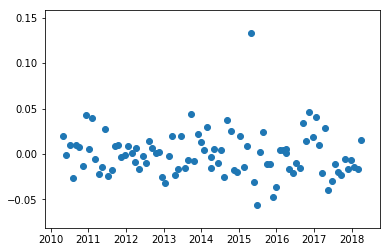

In [50]:
# regression.linear_model.RegressionResults
# results.resid_pearson
# results.model.data.endog
# results.model.data.exog
# results.resid.plot()
plt.scatter(results.resid.index,results.resid)

### 五因子模型检验

In [51]:
df_X5=get_df_X(index_date,{"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml,'rmw':rmw,'cma':cma})
df_X5.describe()

,HML,Rm_Rf,SMB,cma,rmw
count,95.000000,95.000000,95.000000,95.000000,95.000000
mean,-0.008217,0.002328,-0.013002,-0.006765,0.010644
std,0.030692,0.073005,0.054759,0.029092,0.042558
min,-0.099511,-0.223365,-0.213241,-0.131520,-0.110696
25%,-0.020814,-0.040162,-0.033335,-0.016646,-0.013435
50%,-0.007342,0.005440,-0.012613,-0.005898,0.006767
75%,0.008408,0.036263,0.018532,0.008314,0.026979
max,0.077680,0.277888,0.151607,0.053428,0.156627


In [52]:
df_X5.corr(method='pearson')

,HML,Rm_Rf,SMB,cma,rmw
HML,1.000000,0.628058,-0.585750,-0.326369,0.665670
Rm_Rf,0.628058,1.000000,-0.976652,-0.847506,0.935246
SMB,-0.585750,-0.976652,1.000000,0.840351,-0.961277
cma,-0.326369,-0.847506,0.840351,1.000000,-0.792751
rmw,0.665670,0.935246,-0.961277,-0.792751,1.000000


In [53]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 5个因子
ols_model = smf.ols('y ~ HML + Rm_Rf + SMB + CMA + RMW', data=df_xy)
results = ols_model.fit()#cov_type='HC3'
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     209.7
Date:                Sat, 24 Nov 2018   Prob (F-statistic):           1.17e-47
Time:                        11:07:32   Log-Likelihood:                 226.97
No. Observations:                  95   AIC:                            -441.9
Df Residuals:                      89   BIC:                            -426.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0062      0.003     -1.837      0.069      -0.013       0.001
HML            0.2685      0.136      1.973      0.052      -0.002       0.539
Rm_Rf          0.0438      0.183      0.239      0.811      -0.319       0.407
SMB           -1.7413      0.294     -5.919      0.000      -2.326      -1.157
CMA            0.7538      0.181      4.169      0.000       0.394       1.113
RMW           -0.2397      0.240     -1.000      0.320      -0.716       0.237
==============================================================================
Omnibus:                       39.724   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.402
Skew:                           1.156   Prob(JB):                     1.52e-45
Kurtosis:                       9.841   Cond. No.                         165.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
table.SimpleTable(get_vif(results))

Intercept,2.0338192372242676
HML,3.1207271133833
Rm_Rf,31.851437928756784
SMB,46.406280887758115
CMA,4.949437552330437
RMW,18.60956000011142


### 四因子模型检验

In [55]:
df_X4=get_df_X(index_date,{'SMB':smb,'HML':hml,'RMW':rmw,'CMA':cma})
df_X4.describe()

,CMA,HML,RMW,SMB
count,95.000000,95.000000,95.000000,95.000000
mean,-0.006765,-0.008217,0.010644,-0.013002
std,0.029092,0.030692,0.042558,0.054759
min,-0.131520,-0.099511,-0.110696,-0.213241
25%,-0.016646,-0.020814,-0.013435,-0.033335
50%,-0.005898,-0.007342,0.006767,-0.012613
75%,0.008314,0.008408,0.026979,0.018532
max,0.053428,0.077680,0.156627,0.151607


In [56]:
df_X4.corr(method='pearson')

,CMA,HML,RMW,SMB
CMA,1.000000,-0.326369,-0.792751,0.840351
HML,-0.326369,1.000000,0.665670,-0.585750
RMW,-0.792751,0.665670,1.000000,-0.961277
SMB,0.840351,-0.585750,-0.961277,1.000000


In [57]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 4个因子
ols_model = smf.ols('y ~ HML + SMB + RMW + CMA', data=df_xy)
results = ols_model.fit()#cov_type='HC3'
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     264.9
Date:                Sat, 24 Nov 2018   Prob (F-statistic):           6.95e-49
Time:                        11:07:33   Log-Likelihood:                 226.94
No. Observations:                  95   AIC:                            -443.9
Df Residuals:                      90   BIC:                            -431.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0066      0.003     -2.327      0.022      -0.012      -0.001
HML            0.2857      0.115      2.488      0.015       0.058       0.514
SMB           -1.7974      0.177    -10.176      0.000      -2.148      -1.446
RMW           -0.2575      0.227     -1.136      0.259      -0.708       0.193
CMA            0.7348      0.162      4.544      0.000       0.414       1.056
==============================================================================
Omnibus:                       39.373   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.279
Skew:                           1.135   Prob(JB):                     5.93e-46
Kurtosis:                       9.890   Cond. No.                         119.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
table.SimpleTable(get_vif(results))

Intercept,1.4639140307629575
HML,2.2448281699207104
SMB,16.909235795101367
RMW,16.819931004979313
CMA,4.000565215135368


### 三因子301的一些测试

In [59]:
df_X301=get_df_X(index_date,{'SMB':smb,'HML':hml,'CMA':cma})
df_X301.describe()

,CMA,HML,SMB
count,95.000000,95.000000,95.000000
mean,-0.006765,-0.008217,-0.013002
std,0.029092,0.030692,0.054759
min,-0.131520,-0.099511,-0.213241
25%,-0.016646,-0.020814,-0.033335
50%,-0.005898,-0.007342,-0.012613
75%,0.008314,0.008408,0.018532
max,0.053428,0.077680,0.151607


In [60]:
df_X301.corr(method='pearson')

,CMA,HML,SMB
CMA,1.000000,-0.326369,0.840351
HML,-0.326369,1.000000,-0.585750
SMB,0.840351,-0.585750,1.000000


In [61]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 3个因子
ols_model = smf.ols('y ~ HML + SMB + CMA ', data=df_xy)
results = ols_model.fit()#cov_type='HC3'
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     351.7
Date:                Sat, 24 Nov 2018   Prob (F-statistic):           6.45e-50
Time:                        11:07:33   Log-Likelihood:                 226.26
No. Observations:                  95   AIC:                            -444.5
Df Residuals:                      91   BIC:                            -434.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0076      0.003     -2.795      0.006      -0.013      -0.002
HML            0.2261      0.102      2.210      0.030       0.023       0.429
SMB           -1.6319      0.100    -16.323      0.000      -1.830      -1.433
CMA            0.7511      0.161      4.655      0.000       0.431       1.072
==============================================================================
Omnibus:                       34.286   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.199
Skew:                           1.004   Prob(JB):                     1.99e-34
Kurtosis:                       8.931   Cond. No.                         81.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
table.SimpleTable(get_vif(results))

Intercept,1.3310908873960696
HML,1.7753836868628736
SMB,5.398987937250971
CMA,3.9693831249738944


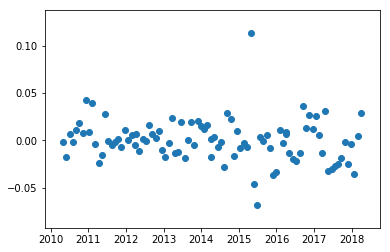

In [63]:
plt.scatter(results.resid.index,results.resid)

### 加入汇率因子的四因子模型

In [64]:
df_X401=get_df_X(index_date,{'SMB':smb,'HML':hml,'CMA':cma,"Exchange":s_exchange_rate})
df_X401.describe()

,CMA,Exchange,HML,SMB
count,95.000000,95.000000,95.000000,95.000000
mean,-0.006765,-0.000848,-0.008217,-0.013002
std,0.029092,0.008558,0.030692,0.054759
min,-0.131520,-0.034406,-0.099511,-0.213241
25%,-0.016646,-0.005557,-0.020814,-0.033335
50%,-0.005898,-0.001542,-0.007342,-0.012613
75%,0.008314,0.001744,0.008408,0.018532
max,0.053428,0.028843,0.077680,0.151607


In [65]:
df_X401.corr(method='pearson')

,CMA,Exchange,HML,SMB
CMA,1.000000,0.119132,-0.326369,0.840351
Exchange,0.119132,1.000000,-0.262394,0.150496
HML,-0.326369,-0.262394,1.000000,-0.585750
SMB,0.840351,0.150496,-0.585750,1.000000


In [66]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 4个因子
ols_model = smf.ols('y ~ HML + SMB + CMA + Exchange ', data=df_xy)
results = ols_model.fit()#cov_type='HC3'
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     261.7
Date:                Sat, 24 Nov 2018   Prob (F-statistic):           1.15e-48
Time:                        11:07:33   Log-Likelihood:                 226.40
No. Observations:                  95   AIC:                            -442.8
Df Residuals:                      90   BIC:                            -430.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0073      0.003     -2.663      0.009      -0.013      -0.002
HML            0.2386      0.106      2.262      0.026       0.029       0.448
SMB           -1.6284      0.101    -16.187      0.000      -1.828      -1.429
CMA            0.7447      0.162      4.584      0.000       0.422       1.067
Exchange       0.1489      0.287      0.518      0.605      -0.422       0.720
==============================================================================
Omnibus:                       34.860   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.850
Skew:                           1.026   Prob(JB):                     5.29e-35
Kurtosis:                       8.972   Cond. No.                         123.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
table.SimpleTable(get_vif(results))

Intercept,1.3670252967545347
HML,1.87389022118481
SMB,5.422862876169521
CMA,3.9922528219854185
Exchange,1.0801470094626258


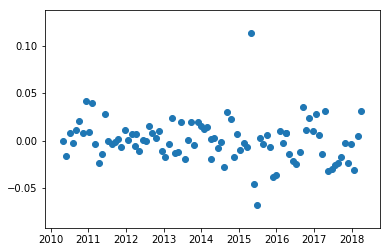

In [68]:
plt.scatter(results.resid.index,results.resid)

### CAPM模型

In [69]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 1个因子
ols_model = smf.ols('y ~ Rm_Rf', data=df_xy)
results = ols_model.fit()#cov_type='HC3'
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     511.4
Date:                Sat, 24 Nov 2018   Prob (F-statistic):           1.43e-39
Time:                        11:07:33   Log-Likelihood:                 194.84
No. Observations:                  95   AIC:                            -385.7
Df Residuals:                      93   BIC:                            -380.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0044      0.003      1.357      0.178      -0.002       0.011
Rm_Rf          1.0050      0.044     22.615      0.000       0.917       1.093
==============================================================================
Omnibus:                       43.997   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.651
Skew:                           1.508   Prob(JB):                     2.62e-34
Kurtosis:                       8.474   Cond. No.                         13.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
### log调整模型

In [71]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 1个因子
ols_model = smf.ols('y ~ HML + SMB + CMA + (np.log(Exchange+1))', data=df_xy)
results = ols_model.fit()#cov_type='HC3'
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     261.8
Date:                Sat, 24 Nov 2018   Prob (F-statistic):           1.15e-48
Time:                        11:07:33   Log-Likelihood:                 226.41
No. Observations:                  95   AIC:                            -442.8
Df Residuals:                      90   BIC:                            -430.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0073      0.003     -2.657      0.009      -0.013      -0.002
HML                      0.2389      0.105      2.265      0.026       0.029       0.448
SMB                     -1.6285      0.101    -16.192      0.000      -1.828      -1.429
CMA                      0.7448      0.162      4.586      0.000       0.422       1.067
np.log(Exchange + 1)     0.1525      0.287      0.531      0.597      -0.418       0.723
==============================================================================
Omnibus:                       34.863   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.831
Skew:                           1.027   Prob(JB):                     5.34e-35
Kurtosis:                       8.971   Cond. No.                         123.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 一些测试检验方案

In [72]:
# import statsmodels.compat.lzip as lzip #No module named 'statsmodels.compat.lzip'
# 应该是lzip是compat的属性，而不是子模块，import 只能引入到模块级别，不能引入到属性活着功能级别
from statsmodels.compat import lzip
import statsmodels.iolib.table as table

def white_test(results):
    name = ['lm statistic', 'lm_pvalue','f-statistic',"f_pvalue"]
    # f-statistic of the hypothesis that the error variance does not depend on x. This is an alternative test variant not the original LM test.
    test = sms.het_white(results.resid, results.model.exog)
    ziped=lzip(name, test)
    # white=sms.het_white(results.resid,results.model.exog)
    white=table.SimpleTable(ziped)
    white.title="White Test"
#     print(white)
    return white
white_test(results)
#     print(white)
#             White Test            
# ==================================
# lm statistic   41.55454399712868  
#  lm_pvalue   3.963585550453876e-06
# f-statistic    7.343179599291278  
#   f_pvalue   7.650453944017435e-08
# ----------------------------------


# sms.het_white?

lm statistic,43.86572279852284
lm_pvalue,6.222022340642782e-05
f-statistic,4.9020204616713565
f_pvalue,1.8864860711252074e-06


In [73]:
#np.log(smb)#负数没有log，所以出现了问题，收益率不好用log来调整，都加1求log好像也不太好的方式，
# /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
#   """Entry point for launching an IPython kernel.
# /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
#   """Entry point for launching an IPython kernel.
# sms.linear_rainbow(results)#(0.835850366394606, 0.7279272220899624)

name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, results.model.exog)
ziped=lzip(name, test)
bp=table.SimpleTable(ziped)
bp
# sms.het_breuschpagan?

Lagrange multiplier statistic,15.492803922176474
p-value,0.0037810272397070417
f-value,4.384358969315991
f p-value,0.0027658309645012605


In [74]:
# Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(results.model.endog, results.model.exog,idx=2)
ziped=lzip(name, test)
gq=table.SimpleTable(ziped)
gq
# sms.het_goldfeldquandt?

F statistic,0.6295679634564687
p-value,0.9319179391191967


In [75]:
# YT=get_y(return_data_ydyl,Rf)
# # YT=get_y(return_data["600000.XSHG"],Rf)
# X = sm.add_constant(X)
# mod = regression.linear_model.OLS(YT, X).fit()
# p = mod.params
# print(p)
# mod.summary()
# #HML	Rm_Rf	SMB	bigdata

In [76]:
# price_data=get_price_cs(data_starttime,data_endtime)#1944 rows × 3631 columns
# price_data

In [77]:
import statsmodels.api as sm
# sm.formula==smf#True
# regression.linear_model.OLS??
# results.compare_lm_test(restricted={"model":{"ssr":results.ssr,"df_resid":results.df_resid}})

In [78]:
# ols_model.whiten(results.resid)
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind,levene
from statsmodels.stats import anova
from statsmodels.stats.anova import anova_lm
# pearsonr??
# results
# levene(df_X.iloc[:,0],df_X.iloc[:,1])
anova_lm(results,test="Chisq")

,df,sum_sq,mean_sq,Chisq,PR(>Chisq)
HML,1.0,0.255638,0.255638,0.0,0.0
SMB,1.0,0.283557,0.283557,0.0,0.0
CMA,1.0,0.011306,0.011306,0.0,0.0
np.log(Exchange + 1),1.0,0.000148,0.000148,0.0,0.0
Residual,90.0,0.047333,0.000526,0.0,0.0


In [79]:
# anova_lm?

([array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 95.]),
  array([ 1., 87.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 6., 71., 17.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1., 88.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 0., 95.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])],
 array([-0.21324096, -0.09191686,  0.02940723,  0.15073133,  0.27205543,
         0.39337952,  0.51470362,  0.63602771,  0.75735181,  0.8786759 ,
         1.        ]),
 <a list of 5 Lists of Patches objects>)

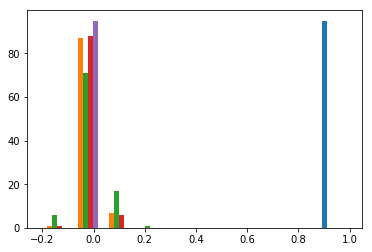

In [80]:
 plt.hist(results.model.exog)

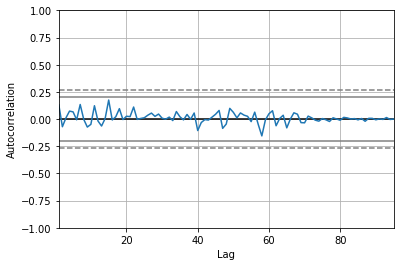

In [81]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_xy)
# autocorrelation_plot(results.resid)

In [82]:
# fig = plt.figure(figsize=(15,8))
# fig = sm.graphics.plot_regress_exog(results, df_X.columns, fig=fig)
# df_X[:,np.array([True,False,True])]
# np.array(df_X)==np.asarray(df_X)

# 大数据因子的各种处理
# df_bigdata_origin=pd.read_csv("bigdata.csv",encoding="gbk",index_col=0)
# df_bigdata_origin
# df_bigdata=pd.Series(df_bigdata_origin["收盘点位"],index=df_bigdata_origin.index,name="bigdata")
# # df_bigdata["close"]=df_bigdata_origin["收盘点位"]
# df_bigdata.index.name="index_date"
# df_bigdata.to_csv("bigdata_close.csv")
# df_bigdata=trans_index(df_bigdata)
# df_bigdata2=df_bigdata[df_bigdata.index.isin(index_date)]
# df_bigdata2.to_csv("bigdata_pure.csv")
# df_bigdata=pd.read_csv("bigdata_pure.csv",index_col=0,header=None)
# df_bigdata["test"]=df_bigdata_origin["收盘点位"]
# df_bigdata

In [83]:
# dfx=df_X.copy()
# dfx["y"]=return_data_ydyl-Rf
# dfx["seq"]=np.arange(len(dfx))
# dfx.index.name="date"
# # dfx.reindex(index=["seq","date"],columns=["HML","Rm_Rf","SMB","bigdata"],copy=True)
# # dfx.index.append(dfx["seq"])
# df=pd.DataFrame(dfx[["HML","Rm_Rf","SMB","bigdata"]].values,index=[dfx["seq"],dfx.index],columns=["HML","Rm_Rf","SMB","bigdata"])
# df

In [84]:
# price_data.apply(lambda x:x)
# np.percentile([1,2,np.nan,4,5],40)
# price_data.dropna(axis=1,how='all') 
# fm  = pd.fama_macbeth(y=df['y'],x=df[["HML","Rm_Rf","SMB","bigdata"]])
# fm
df_xy

,CMA,Exchange,HML,RMW,Rm_Rf,SMB,bigdata,y
date,,,,,,,,
2010-05-04,0.051764,0.000132,-0.071589,-0.059653,-0.115266,0.072521,-0.165773,-0.104910
2010-06-04,0.045896,0.000322,-0.049275,-0.055799,-0.092520,0.063869,-0.012993,-0.105708
2010-07-06,0.022781,-0.007058,-0.005557,-0.021232,-0.067556,0.033867,-0.074541,-0.040206
2010-08-06,-0.073459,-0.001799,0.015207,0.068714,0.129191,-0.090692,0.126561,0.086355
2010-09-08,-0.016918,0.003827,-0.032602,0.009074,0.027325,-0.017744,0.082382,0.012323
2010-10-08,-0.031813,-0.017986,-0.031514,0.022023,0.019798,-0.024794,0.043332,0.019695
2010-11-10,-0.088691,-0.005680,0.018759,0.112015,0.147831,-0.130030,0.441792,0.149638
2010-12-10,0.028092,0.003196,-0.029972,-0.047111,-0.097940,0.060862,0.066641,-0.050064
2011-01-11,0.002075,-0.005409,0.007826,-0.003005,-0.013594,0.005458,-0.191509,-0.004565


In [85]:
# df = pd.DataFrame({
#         'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
#         'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
#         'C': np.random.randn(8),
#         'D': np.random.randn(8)
#     })

# def fmreg(data,formula):
#     return smf.ols(formula,data=data).fit().params

# res=df_xy.groupby('date').apply(fmreg,'y~HML+Rm_Rf+SMB')

In [86]:
# df.groupby("A").mean()
# ss=pd.Series([3,3,3,np.nan,44])
# type(ss.value_counts(dropna=1))
# type(pd.pivot_table(df, values='D', index=['A', 'B'], columns=['C']))#pd.pivot_table(df, values='D', index=['A', 'B'], columns=['C'])

In [87]:
# ?smf.wls()
ols_model3=smf.wls('y ~ HML + SMB +bigdata', data=df_xy)
results3 = ols_model3.fit()#cov_type='HC3'
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.905
Model:                            WLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     287.7
Date:                Sat, 24 Nov 2018   Prob (F-statistic):           2.69e-46
Time:                        11:07:34   Log-Likelihood:                 217.55
No. Observations:                  95   AIC:                            -427.1
Df Residuals:                      91   BIC:                            -416.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0067      0.003     -2.246      0.027      -0.013      -0.001
HML            0.3180      0.116      2.733      0.008       0.087       0.549
SMB           -1.3309      0.081    -16.499      0.000      -1.491      -1.171
bigdata       -0.0433      0.026     -1.672      0.098      -0.095       0.008
==============================================================================
Omnibus:                       38.647   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.933
Skew:                           1.289   Prob(JB):                     3.04e-30
Kurtosis:                       8.262   Cond. No.                         51.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
white_test(results3)

lm statistic,45.286687290103
lm_pvalue,8.165623352960655e-07
f-statistic,8.603482223769761
f_pvalue,4.693342508801062e-09


In [89]:
df_market

,abbrev_symbol,board_type,de_listed_date,exchange,industry_code,industry_name,listed_date,order_book_id,round_lot,sector_code,sector_code_name,special_type,status,symbol,type
0,LGHK,SMEBoard,0000-00-00,XSHE,C38,电气机械和器材制造业,2009-12-18,002322.XSHE,100.0,Industrials,工业,Normal,Active,理工环科,CS
1,ZTDQ,MainBoard,0000-00-00,XSHG,C38,电气机械和器材制造业,2010-01-21,601877.XSHG,100.0,Industrials,工业,Normal,Active,正泰电器,CS
2,XZGF,SMEBoard,0000-00-00,XSHE,C34,通用设备制造业,2010-09-21,002480.XSHE,100.0,Industrials,工业,Normal,Active,新筑股份,CS
3,WZXC,SMEBoard,0000-00-00,XSHE,C29,橡胶和塑料制品业,2014-12-03,002735.XSHE,100.0,Materials,原材料,Normal,Active,王子新材,CS
4,ZXGA,MainBoard,0000-00-00,XSHE,I63,电信、广播电视和卫星传输服务,1997-10-31,000839.XSHE,100.0,ConsumerDiscretionary,非必须消费品,Normal,Active,中信国安,CS
5,FLTK,MainBoard,0000-00-00,XSHG,C34,通用设备制造业,2017-01-25,603966.XSHG,100.0,Industrials,工业,Normal,Active,法兰泰克,CS
6,ASK,GEM,0000-00-00,XSHE,C35,专用设备制造业,2016-07-05,300521.XSHE,100.0,Industrials,工业,Normal,Active,爱司凯,CS
7,JFKJ,SMEBoard,0000-00-00,XSHE,C34,通用设备制造业,2007-12-26,002202.XSHE,100.0,Industrials,工业,Normal,Active,金风科技,CS
8,XQGF,GEM,0000-00-00,XSHE,C30,非金属矿物制品业,2011-01-13,300160.XSHE,100.0,Materials,原材料,Normal,Active,秀强股份,CS
9,HTDQ,SMEBoard,0000-00-00,XSHE,C39,计算机、通信和其他电子设备制造业,2004-07-26,002025.XSHE,100.0,Industrials,工业,Normal,Active,航天电器,CS


In [90]:
# s_exchange.to_csv("exchange_day.csv")
df_tt=df_market[df_market['order_book_id'].isin(arr_ydyl)]
# arr_ydyl
# df_tt[['order_book_id','symbol']]
df_industry=df_tt.groupby('industry_name').size()#pandas.core.series.Series
# table.SimpleTable(lzip(df_industry.index,df_industry.data))
df_industry

df_sector=df_tt.groupby('sector_code_name').size()
df_sector

sector_code_name
信息技术        7
公用事业        6
原材料        17
工业        102
必需消费品       1
能源         13
金融          5
非必须消费品      6
dtype: int64

In [91]:
s1=set([4,15,6])
s2=set([4,1])
s1.difference(s2)
# s2.difference(s1)
# s1|s2
# s1.intersection(s2)
# s2.intersection(s1)

{6, 15}

In [92]:
s_cap=df_market_cap[arr_ydyl].loc["2018-03-30"]
s_cap

000022.XSHE    1.556460e+10
000042.XSHE    1.045779e+10
000065.XSHE    9.095554e+09
000088.XSHE    1.417806e+10
000090.XSHE    1.171434e+10
000151.XSHE    5.259565e+09
000157.XSHE    3.281294e+10
000159.XSHE    2.193995e+09
000400.XSHE    1.142435e+10
000425.XSHE    2.733014e+10
000498.XSHE    6.832848e+09
000507.XSHE    7.169032e+09
000528.XSHE    1.001466e+10
000564.XSHE    2.871742e+10
000582.XSHE    1.189673e+10
000610.XSHE    2.348539e+09
000617.XSHE    1.210931e+11
000672.XSHE    9.942435e+09
000680.XSHE    5.409834e+09
000703.XSHE    4.287552e+10
000777.XSHE    5.287329e+09
000797.XSHE    9.079049e+09
000852.XSHE    4.952746e+09
000862.XSHE    2.718558e+09
000877.XSHE    1.115841e+10
000905.XSHE    5.182560e+09
000928.XSHE    6.873946e+09
000939.XSHE    1.960868e+10
000978.XSHE    2.740361e+09
600026.XSHG    2.177298e+10
                   ...     
600023.XSHG    7.521182e+10
300523.XSHE    9.126720e+09
300374.XSHE    3.447691e+09
603969.XSHG    5.456000e+09
603569.XSHG    8.920

In [93]:
# s_cap.to_csv("s_cap.csv")